# Imports

In [1]:
import torch
import torch.nn as nn

import numpy as np

# Training Phase

Assumptions

```
dataloader = {'train': train_dataloader,
              'valid': valid_dataloader}

network: nn.Module = NeuralNetwork()

loss_function: torch.nn.LOSS_FUNCTION

optimizer: torch.optim.Optimizer
```



In [2]:
from tqdm import tqdm 

In [3]:
def training_phase(epochs: int,
                   network,
                   dataloader,
                   loss_function,
                   optimizer,
                   device):
  
  train_losses, valid_losses = [], []

  for epoch in tqdm(range(epochs), desc=' > Epochs: '):

    train_loss, valid_loss = training_step(train_losses,
                                           valid_losses,
                                           network,
                                           dataloader,
                                           loss_function,
                                           optimizer,
                                           device
                                           )
    plot_loss(train_losses, valid_losses)

  return 

## Training Step

In [4]:
def training_step(train_losses,
                  valid_losses,
                  network,
                  dataloader,
                  loss_function,
                  optimizer,
                  device):
  
  train_loss = train_one_epoch(network, dataloader,
                               loss_function, optimizer,
                               device)
  valid_loss = validate_one_epoch(network, dataloader,
                                  loss_function, optimizer,
                                  device)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  return train_loss, valid_loss

### Train one epoch

These two have different goals: 

**model.eval()** will notify all your layers that you are in eval mode, that way, **batchnorm** or **dropout layers** will work in eval mode instead of training mode. 

**torch.no_grad()** impacts the autograd engine and deactivate it. It will reduce memory usage and speed up ...

In [5]:
def train_one_epoch(network, dataloader,
                    loss_function, optimizer,
                    device):
  network.train()

  losses = []

  for images, labels in dataloader['train']:

      output = network(images)
      loss = loss_function(output, labels)
      losses.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  return np.mean(losses)

### Validate one epoch

In [6]:
def validate_one_epoch(network, dataloader,
                       loss_function, optimizer,
                       device):
  network.eval()

  losses = []

  with torch.no_grad():
      for images, labels in dataloader['valid']:

          output = network(images)
          loss = loss_function(output, labels)
          losses.append(loss.item())

          losses.append(loss)

      return np.mean(losses)

## Loss Evaluation

In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_loss(train_losses, valid_losses):
  plt.plot(train_losses, c='r', label='Training Loss')
  plt.plot(valid_losses, c='b', label='Validation Loss')

  plt.legend()
  plt.show()

# Training Phase - Use Case

## Initialization

Definitions:

- Dataset
- Network
- Loss Function
- Optimizer

### Hyperparameters

In [49]:
# Dataset
BATCH_SIZE = 128

# Network
IN_CHANNELS = 3
OUT_CHANNELS = 4
KERNEL_SIZE = 5
POOL_SIZE = 2

# Training
LEARNING_RATE = 0.001


### Dataset

In [50]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Dataset
training_data = datasets.CIFAR10(root='data',
                                 download=True,
                                 train=True,
                                 transform=transform)

valid_data = datasets.CIFAR10(root='data',
                             download=True,
                             train=False,
                             transform=transform)

# Dataloader
batch_size = BATCH_SIZE

train_dataloader = DataLoader(dataset=training_data,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True)

valid_dataloader = DataLoader(dataset=valid_data,
                             batch_size=batch_size,
                             shuffle=True,
                             drop_last=True)

dataloader = {'train': train_dataloader,
              'valid': valid_dataloader}

Files already downloaded and verified
Files already downloaded and verified


### Neural Network

In [51]:
def init_weights(m):
  try:
    torch.nn.init.xavier_normal_(m.weight)
    m.bias.data.fill_(0.01)
  except:
    pass

In [52]:
import torch.nn as nn
import torch.nn.functional as F

N_CLASSES = 10

class NeuralNetwork(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, pool_size, n_classes):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.pool_1 = nn.MaxPool2d(pool_size, pool_size)
        self.conv_2 = nn.Conv2d(out_channels, out_channels*2, kernel_size)
        self.pool_2 = nn.MaxPool2d(pool_size, pool_size)

        input_size = out_channels*2 * kernel_size * kernel_size
        self.fc1 = nn.Linear(input_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 8)
        self.fc3 = nn.Linear(input_size // 8, n_classes)

    def forward(self, x):
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        #x = self.fc3(x)

        return x

network = NeuralNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)
#network.apply(init_weights)

network

NeuralNetwork(
  (conv_1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)

### Loss Function

In [53]:
# Loss function
loss_function = nn.CrossEntropyLoss()

### Optimization

In [54]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

## Training

 > Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


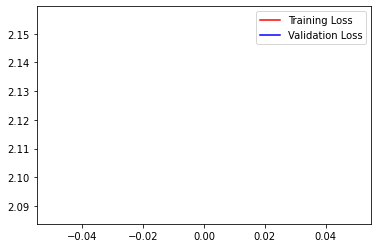

 > Epochs:   2%|▏         | 1/50 [00:16<13:47, 16.89s/it]

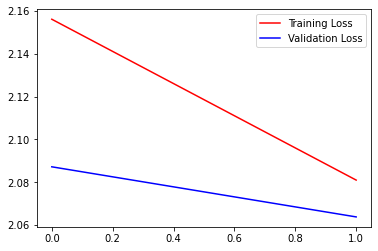

 > Epochs:   4%|▍         | 2/50 [00:33<13:30, 16.89s/it]

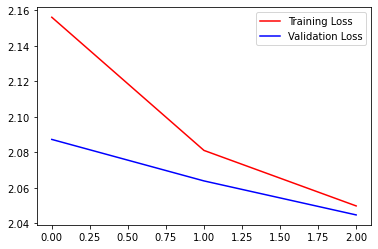

 > Epochs:   6%|▌         | 3/50 [00:50<13:12, 16.87s/it]

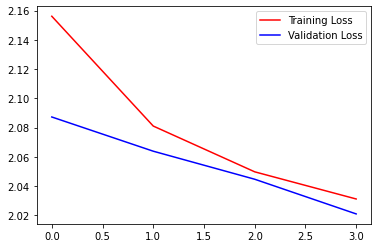

 > Epochs:   8%|▊         | 4/50 [01:07<12:56, 16.88s/it]

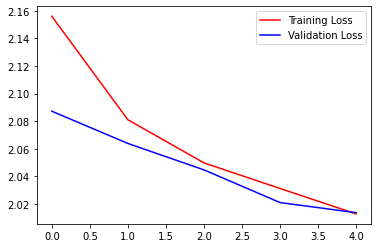

 > Epochs:  10%|█         | 5/50 [01:24<12:38, 16.86s/it]

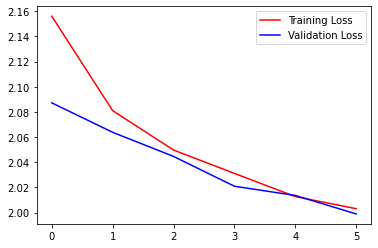

 > Epochs:  12%|█▏        | 6/50 [01:41<12:23, 16.89s/it]

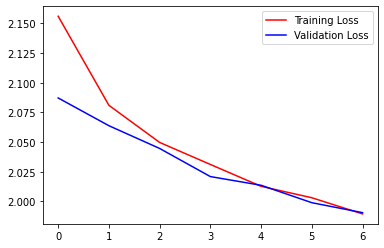

 > Epochs:  14%|█▍        | 7/50 [01:58<12:07, 16.92s/it]

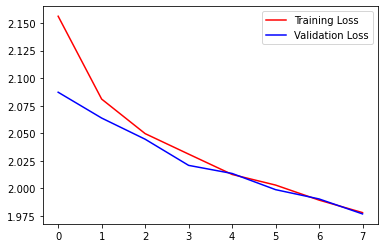

 > Epochs:  16%|█▌        | 8/50 [02:15<11:51, 16.95s/it]

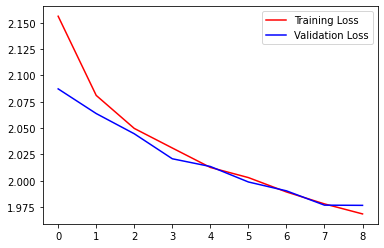

 > Epochs:  18%|█▊        | 9/50 [02:32<11:36, 17.00s/it]

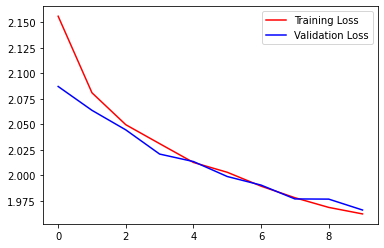

 > Epochs:  20%|██        | 10/50 [02:49<11:20, 17.01s/it]

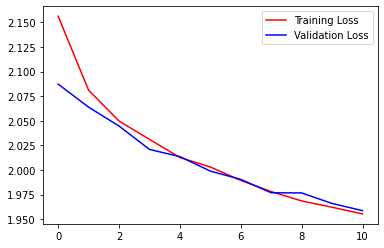

 > Epochs:  22%|██▏       | 11/50 [03:06<11:02, 16.99s/it]

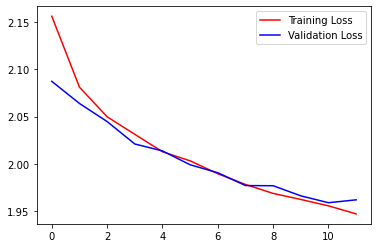

 > Epochs:  24%|██▍       | 12/50 [03:23<10:41, 16.89s/it]

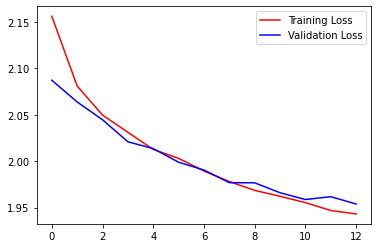

 > Epochs:  26%|██▌       | 13/50 [03:39<10:23, 16.85s/it]

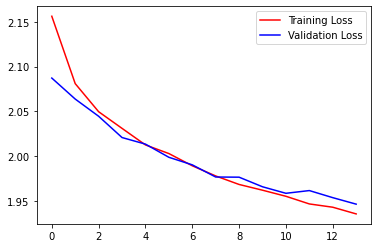

 > Epochs:  28%|██▊       | 14/50 [03:56<10:06, 16.84s/it]

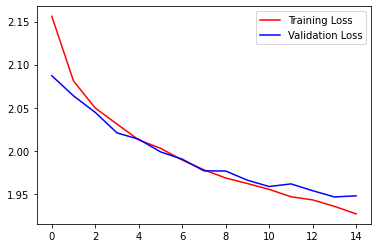

 > Epochs:  30%|███       | 15/50 [04:13<09:51, 16.91s/it]

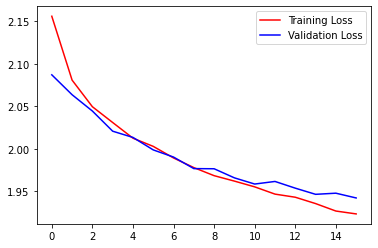

 > Epochs:  32%|███▏      | 16/50 [04:30<09:37, 16.97s/it]

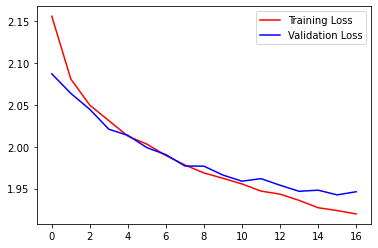

 > Epochs:  34%|███▍      | 17/50 [04:47<09:16, 16.88s/it]

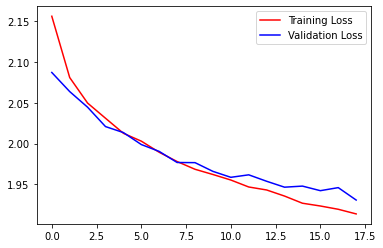

 > Epochs:  36%|███▌      | 18/50 [05:04<08:58, 16.81s/it]

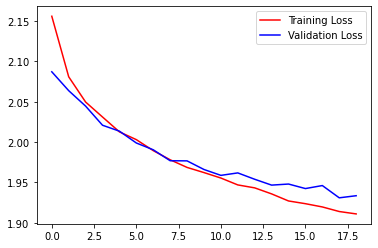

 > Epochs:  38%|███▊      | 19/50 [05:20<08:40, 16.78s/it]

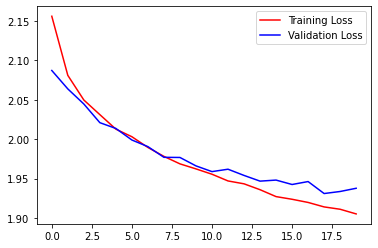

 > Epochs:  40%|████      | 20/50 [05:37<08:21, 16.72s/it]

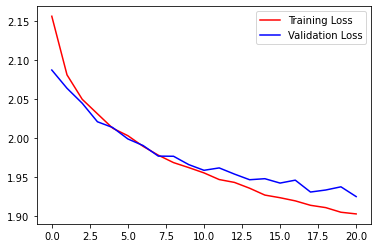

 > Epochs:  42%|████▏     | 21/50 [05:53<08:03, 16.66s/it]

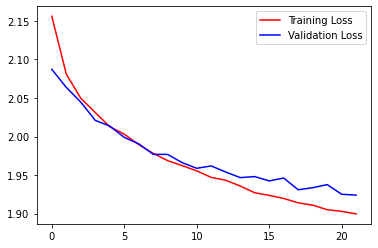

 > Epochs:  44%|████▍     | 22/50 [06:10<07:45, 16.64s/it]

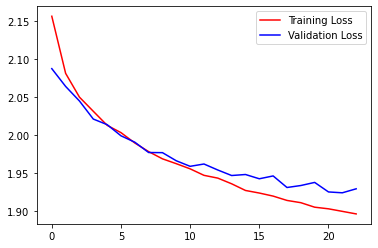

 > Epochs:  46%|████▌     | 23/50 [06:27<07:28, 16.61s/it]

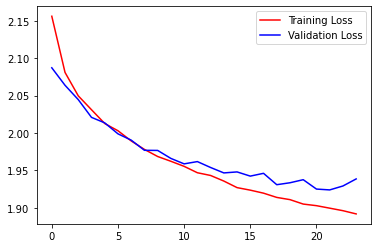

 > Epochs:  48%|████▊     | 24/50 [06:43<07:14, 16.69s/it]

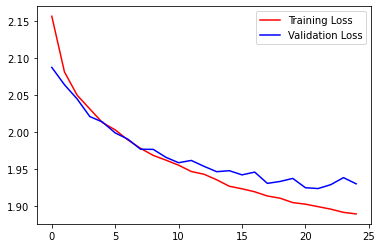

 > Epochs:  50%|█████     | 25/50 [07:00<06:56, 16.64s/it]

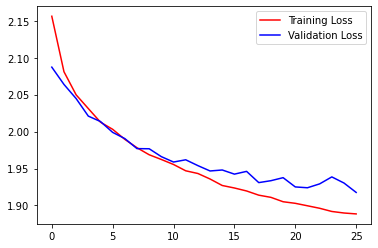

 > Epochs:  52%|█████▏    | 26/50 [07:17<06:40, 16.67s/it]

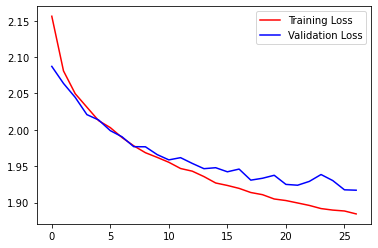

 > Epochs:  54%|█████▍    | 27/50 [07:33<06:22, 16.65s/it]

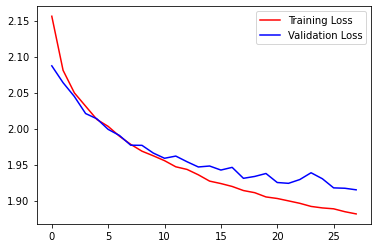

 > Epochs:  56%|█████▌    | 28/50 [07:50<06:05, 16.63s/it]

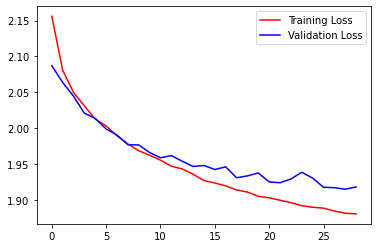

 > Epochs:  58%|█████▊    | 29/50 [08:07<05:49, 16.65s/it]

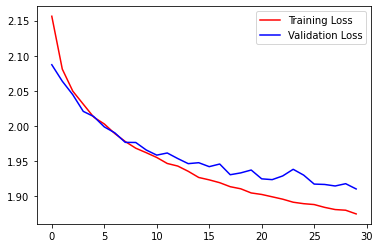

 > Epochs:  60%|██████    | 30/50 [08:23<05:33, 16.68s/it]

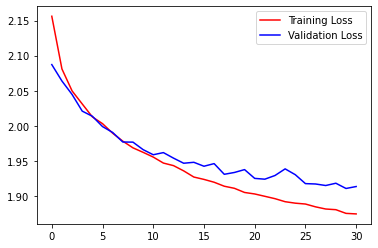

 > Epochs:  62%|██████▏   | 31/50 [08:40<05:18, 16.74s/it]

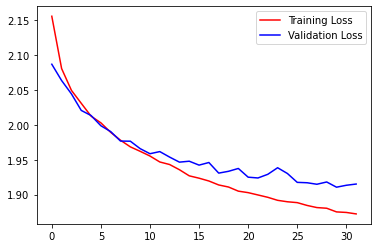

 > Epochs:  64%|██████▍   | 32/50 [08:57<05:01, 16.73s/it]

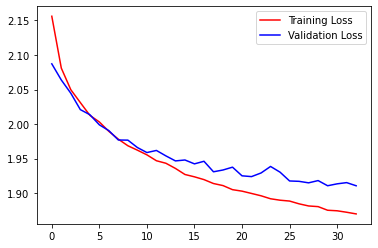

 > Epochs:  66%|██████▌   | 33/50 [09:14<04:44, 16.71s/it]

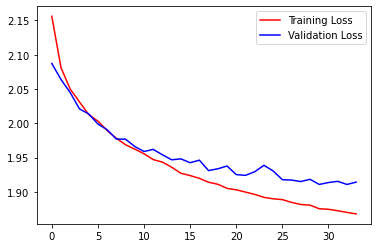

 > Epochs:  68%|██████▊   | 34/50 [09:30<04:27, 16.73s/it]

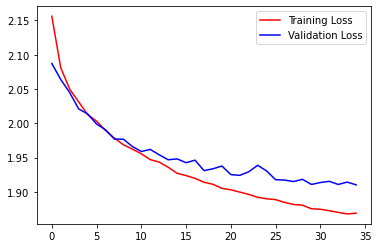

 > Epochs:  70%|███████   | 35/50 [09:47<04:10, 16.73s/it]

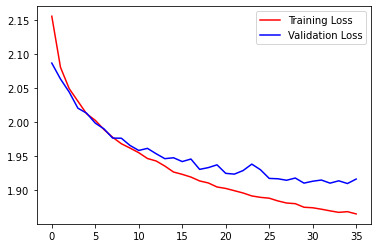

 > Epochs:  72%|███████▏  | 36/50 [10:04<03:53, 16.67s/it]

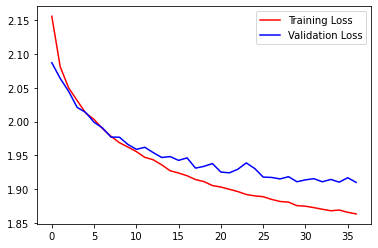

 > Epochs:  74%|███████▍  | 37/50 [10:21<03:37, 16.77s/it]

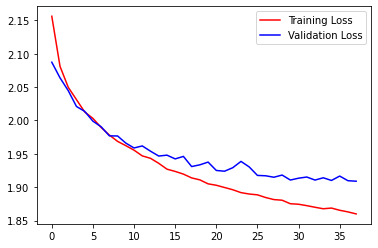

 > Epochs:  76%|███████▌  | 38/50 [10:37<03:20, 16.74s/it]

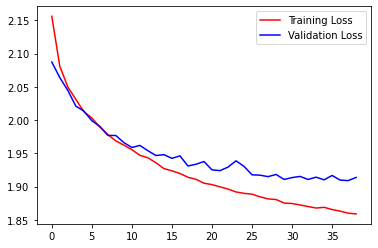

 > Epochs:  78%|███████▊  | 39/50 [10:54<03:04, 16.77s/it]

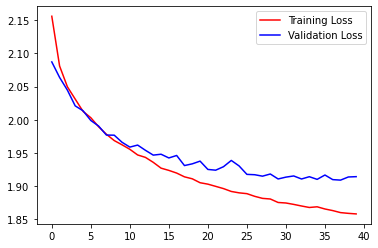

 > Epochs:  80%|████████  | 40/50 [11:11<02:47, 16.79s/it]

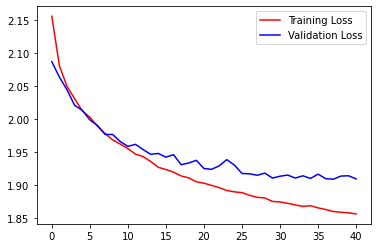

 > Epochs:  82%|████████▏ | 41/50 [11:34<02:32, 16.93s/it]


KeyboardInterrupt: ignored

In [55]:
EPOCHS = 50
DEVICE = 'cuda'

training_phase(epochs = EPOCHS,
               network = network,
               dataloader = dataloader,
               loss_function = loss_function,
               optimizer = optimizer,
               device = DEVICE)

# Inference

In [74]:
def inference(x,
              network):
  
  print(f' > Input image shape: {x.shape}')
  plt.imshow(x)
  plt.show()

  x = torch.Tensor(x)
  x = x.transpose(0,2)
  x = x.transpose(1,2)
  x = x.unsqueeze(0)

  print(f'\n\n > Image shape preprocessed: {x.shape}\n')

  with torch.no_grad():
    print('--- Inference ---\n')
    output = network(x)
    output = output.squeeze()
    print(f' > Output shape: {output.shape}')
    print(f' > Output value: {output}\n\n')

  return output

 > Input image shape: (32, 32, 3)


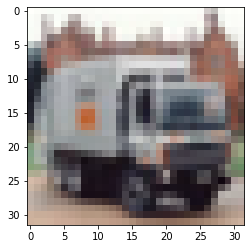



 > Image shape preprocessed: torch.Size([1, 3, 32, 32])

--- Inference ---

 > Output shape: torch.Size([10])
 > Output value: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


 > Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 > Class Index: 9


 > Class Name predicted: truck





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [76]:
image = valid_dataloader.dataset.data[11]

output = inference(image, network)
output = output.numpy()

class_index = np.where(output==np.max(output))[0].item()
class_name = valid_dataloader.dataset.classes[class_index]

print(f' > Classes: {valid_dataloader.dataset.classes}')
print(f' > Class Index: {class_index}\n\n')

print(f' > Class Name predicted: {class_name}\n\n\n')

# Save & Load Model

## Entire model

Saving a model in this way will save the entire module using Python’s pickle module. The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. 

In [82]:
# Saving
torch.save(network, 'model.pth')

 > Input image shape: (32, 32, 3)


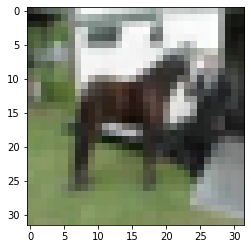



 > Image shape preprocessed: torch.Size([1, 3, 32, 32])

--- Inference ---

 > Output shape: torch.Size([10])
 > Output value: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


 > Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 > Class Index: 7


 > Class Name predicted: horse





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [83]:
# Loading
loaded_network = torch.load('model.pth')

image = valid_dataloader.dataset.data[20]
output = inference(image, loaded_network)
output = output.numpy()

class_index = np.where(output==np.max(output))[0].item()
class_name = valid_dataloader.dataset.classes[class_index]

print(f' > Classes: {valid_dataloader.dataset.classes}')
print(f' > Class Index: {class_index}\n\n')

print(f' > Class Name predicted: {class_name}\n\n\n')

## State Dict

In [ ]:
network_state = network.state_dict()

print(f' > Parameters keys: {network_state.keys()}\n')
print(f' > Example of parameters for a conv_1_weight:\n\nShape: {network_state["conv_1.weight"].shape}\n\nValue: {network_state["conv_1.weight"]}')

 > Parameters keys: odict_keys(['conv_1.weight', 'conv_1.bias', 'conv_2.weight', 'conv_2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

 > Example of parameters for a conv_1_weight:

Shape: torch.Size([4, 3, 5, 5])

Value: tensor([[[[-0.0224,  0.0441, -0.0230, -0.0294,  0.0614],
          [ 0.0146, -0.1116, -0.1284,  0.1000,  0.1623],
          [ 0.0210, -0.0228,  0.1464,  0.0503, -0.1483],
          [-0.0032, -0.0538, -0.0680,  0.0053, -0.1811],
          [-0.1575,  0.1140, -0.0428, -0.0787, -0.0541]],

         [[ 0.0746,  0.0295, -0.0114,  0.0096, -0.0075],
          [ 0.0523,  0.1329,  0.0191, -0.1638, -0.1104],
          [-0.0172, -0.0585,  0.0082, -0.1021, -0.0143],
          [-0.2250,  0.0758, -0.0621, -0.0863,  0.0401],
          [-0.0888,  0.2756, -0.0561,  0.0725, -0.0185]],

         [[ 0.1424, -0.0359,  0.1989, -0.0659,  0.0838],
          [ 0.2261, -0.0163, -0.0203, -0.0467,  0.0373],
          [-0.0921,  0.2276, -0.0823,  0.1258, -0

In [ ]:
torch.save(network.state_dict(), 'model_state')

In [ ]:
# Init Network
network = NeuralNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)

# Load state dict
network.load_state_dict(torch.load('model_state'))

<All keys matched successfully>

## Checkpoint

In [ ]:
# Saving model checkpoint

checkpoint = {
            'epochs': EPOCHS,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }

torch.save(checkpoint, 'model_checkpoint.pth')

In [ ]:
# Loading model checkpoint

network = NeuralNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)
optimizer = optim.SGD(network.parameters(), lr=LEARNING_RATE)

checkpoint = torch.load('model_checkpoint.pth')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epochs']
loss = checkpoint['loss']